# Fuzzy Matching

Every enterprise has data. And that data is not always complete, specific, or compliant to a standard. Raw data is collected in the data lake, but recurrent mistakes happen. Periodically, we need to curate the lake by matching raw data, avoiding duplicates, and linking records to a master standard.

For example, restaurant data at http://www.cs.utexas.edu/users/ml/riddle/data.html from two different sources, have duplicates. But since the two record-sets come from two different vendors, we have the responsibility to remove the duplicates.

## Data

The input data is in ARFF (Weka) format. The data is from two vendors -- Zagat and Fodor -- but merged into a single file.

In [1]:
# Read ARFF data
import arff

zf_data = arff.load(open('fz.arff', 'rb'))

# Read ARFF as Pandas frame
zf_pd = pd.DataFrame.from_records(
    zf_data['data'], columns=map(lambda x: x[0], zf_data['attributes'])).drop(
        'class', axis=1)

# Create a tracking ID for each entry
zf_pd['record_id'] = zf_pd.index

# Display Data
display(zf_pd)

,name,addr,city,phone,type,record_id
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,american,0
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,1
2,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,2
...,...,...,...,...,...,...
861,tu lan,8 sixth st.,san francisco,415-626-0927,vietnamese,861
862,vicolo pizzeria,201 ivy st.,san francisco,415-863-2382,pizza,862
863,wa-ha-ka oaxaca mexican grill,2141 polk st.,san francisco,415-775-1055,mexican,863


## Curate

The data is raw. Let us curate some of these fields to a cleaner form so we can compare all records.

In [2]:
# Given a irregular address with non canonical names like street, road etc to St, Rd etc.
# Also reformat the order of the address components.
from streetaddress import StreetAddressFormatter, StreetAddressParser
addr_parser = StreetAddressParser()
addr_formatter = StreetAddressFormatter()


# Take the raw form address
def curate_address(address):
    def street_norm(street):
        if not street:
            return ''  # Return if empty
        # Convert street suffixes like 13th, 2nd, 3rd correctly
        street = addr_formatter.append_TH_to_street(street)
        # Convert North, West, East, South, N E W S
        street = addr_formatter.abbrev_direction(street)
        # Convert Street, Avenue, Circle, Boulevard etc
        street = addr_formatter.abbrev_street_avenue_etc(street)
        street = addr_formatter.abbrev_street_avenue_etc(
            street, abbrev_only_last_token=True)
        # Return normal form
        return street

    # Parse the address and curate
    addr = addr_parser.parse(address)

    # Return normalized form
    return street_norm((addr['house'] if addr and 'house' in addr and addr[
        'house'] else '') + u' ' + addr['street_full']
                       if addr and 'street_full' in addr and addr[
                           'street_full'] else address)


#Given a phone number, clean the number to a "national" form exluding the international code 
# and stripping non numeric characters
import phonenumbers
def remove_non_numbers(val):
    return re.sub(r'([^\w\d])+', '', val.lower()).strip() if val else ''

#use phonenumbers library
def curate_phone(ph_number, country):
    z = None
    # Safely process numbers
    try:
        z = phonenumbers.parse(ph_number, country)
    except:
        # default to input if parsing failed
        return remove_non_numbers(
            phonenumbers.format_number(z,
                                       phonenumbers.PhoneNumberFormat.NATIONAL)
            if z and phonenumbers.is_possible_number(z) else ph_number)
    
    # Strip all non-alphanumeric characters for each country uses its own style
    return remove_non_numbers(
        phonenumbers.format_number(z, phonenumbers.PhoneNumberFormat.NATIONAL)
        if z and phonenumbers.is_possible_number(z) else ph_number)

# Process the address forms
zf_pd['cured_addr'] = zf_pd['addr'].apply(lambda addr: curate_address(addr))

# Process the phone numbers for US geo
zf_pd['cured_phone'] = zf_pd['phone'].apply(lambda phone: curate_phone(phone, 'US'))

# Display the curated address
display(zf_pd)

,name,addr,city,phone,type,record_id,cured_addr,cured_phone
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,american,0,435 s la cienega blv,3102461501
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,1,435 s la cienega blvd,3102461501
2,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,2,12224 ventura blvd,8187621221
...,...,...,...,...,...,...,...,...
861,tu lan,8 sixth st.,san francisco,415-626-0927,vietnamese,861,8 sixth st,4156260927
862,vicolo pizzeria,201 ivy st.,san francisco,415-863-2382,pizza,862,201 ivy st,4158632382
863,wa-ha-ka oaxaca mexican grill,2141 polk st.,san francisco,415-775-1055,mexican,863,2141 polk st,4157751055


## Preliminary Matching

The curated forms are great for comparison. But in a small environment and multitude of recors, comparing every record with every other record is a computationally expensive operation. So we want to first identify candidates that will even have a likely match. This first pass is used to idetify preliminry candidates for match.

In [3]:
import abbreviate, itertools, re

# Generate abbreviations for normal english words
abbr = abbreviate.Abbreviate()

# Use snowball stemmer for stemming lemma forms to norm
from nltk.stem.snowball import SnowballStemmer

# Exclude stop words
from nltk.corpus import stopwords

# Parse sentences into words
from nltk.tokenize import wordpunct_tokenize

# Stop word set to exclude from analysis
stop_words = set(stopwords.words('english'))

# Remove all punctuation
stop_words.update(['st', 'rd', 'blvd', '.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) # remove punctuation too

# Create a stemmer
stemmer2 = SnowballStemmer("english")

# Given contiguous characters or lists of items, select windows
# hello world --> 'hell', 'ello', 'llo ', ...
def window(fseq, window_size=4):
    return [u''.join(fseq[i : i + window_size]) for i in xrange(len(fseq) - window_size + 1)]

# given contiguous characters or lists of items, select their equivalent phonex codes
# wife and wives become WV0
def tosndx(listofelems, window_size=4):
    import fuzzy
    soundex = fuzzy.Soundex(window_size)
    def safesfdx(token):
        try:
            return soundex(token)
        except:
            return token
    return [safesfdx(token) for token in listofelems]

def shred(spacefseq, window_size=4):
    # Convert input into lower case and remove all trailing whitespace
    spacefseq = spacefseq.lower().strip()
    
    # Take alphanumeric words only; i-Pod counts as i, pod
    pattern = re.compile(r'[^a-zA-Z]')
    
    # Break up a long sentence into words
    list_of_words = [i for i in wordpunct_tokenize(spacefseq) if i not in stop_words]
    
    # Remove stop words, stem words, convert to abbreviation codes
    toks = [y for y in list(itertools.chain.from_iterable(
                itertools.chain([re.split(pattern, x) for x in 
                                 [abbr.abbreviate(stemmer2.stem(x.strip()), window_size) for x in list_of_words] if x]))) if y]
    
    #Convert abbreviations into soundex codes as well
    #For safety with ommitting any "good signals", also keep raw words from original string
    ordered_toks = list_of_words + tosndx(toks) + tosndx(list_of_words) + window(u''.join(sorted(list_of_words)), 4)
    return [x for x in ordered_toks if x]

# Form a compound field to compare records; in unicode form
zf_pd['cmp_field'] = zf_pd.apply(lambda row: shred(u' '.join(map(unicode, [row['name'], row['cured_addr'], row['cured_phone']]))), axis=1)

# Reducing dimensions. The number of features in a compound field can be many. If there are plenty,
# it is perhaps best to use minhash technique to reduce dimensions to a fixed 64-dimensional space
# Compute hash of a sequence
# Use Charikar, Andrei Broder's minhash technique
from datasketch import MinHash
def minhash(rec_id, listelems):
    m = MinHash(num_perm=64)
    for elem in listelems:
        m.update(elem)
    return [(rec_id, long(x)) for x in m.hashvalues]

# Compute compound hash
zf_pd['cmp_hash'] = zf_pd.apply(lambda x: minhash(x['record_id'], x['cmp_field']), axis=1)

# Display a preview of the compound field and its hash
display(zf_pd)

,name,addr,city,phone,...,cured_addr,cured_phone,cmp_field,cmp_hash
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,...,435 s la cienega blv,3102461501,"[arnie, morton, chicago, 435, la, cienega, blv...","[(0, 130812145), (0, 43083481), (0, 52160122),..."
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,...,435 s la cienega blvd,3102461501,"[arnie, morton, chicago, 435, la, cienega, 310...","[(1, 217800438), (1, 43083481), (1, 52160122),..."
2,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,...,12224 ventura blvd,8187621221,"[art, delicatessen, 12224, ventura, 8187621221...","[(2, 92970434), (2, 133184892), (2, 202028092)..."
...,...,...,...,...,...,...,...,...,...
861,tu lan,8 sixth st.,san francisco,415-626-0927,...,8 sixth st,4156260927,"[tu, lan, 8, sixth, 4156260927, T000, L500, S2...","[(861, 56719790), (861, 390004977), (861, 2302..."
862,vicolo pizzeria,201 ivy st.,san francisco,415-863-2382,...,201 ivy st,4158632382,"[vicolo, pizzeria, 201, ivy, 4158632382, V240,...","[(862, 183966125), (862, 120040005), (862, 178..."
863,wa-ha-ka oaxaca mexican grill,2141 polk st.,san francisco,415-775-1055,...,2141 polk st,4157751055,"[wa, -, ha, -, ka, oaxaca, mexican, grill, 214...","[(863, 11577476), (863, 21062691), (863, 64412..."


### Candidates

Find the preliminary candidates for matching from the compound field.

In [4]:
# Flatten-explode the hash vector so we can find candidates that match any "feature" hash
flat_records = zf_pd.cmp_hash.apply(pd.Series).unstack().dropna().to_frame(
    'hash')
flat_records['record_id'] = flat_records.hash.apply(lambda x: x[0])
flat_records['hash'] = flat_records.hash.apply(lambda x: x[1])

# Now self-join on hash to find ids that have some similarity
candidates = flat_records.merge(
    flat_records, how='inner', left_on='hash', right_on='hash').drop(
        'hash', axis=1)

# Well, duh!, records will be similar to themselves of course... so filter then out
# Also compute only lower triangular matrix, because similarity is commutative
candidates.drop_duplicates(subset=['record_id_x', 'record_id_y'], inplace=True)

# Filter out upper triangular matrix
candidates = candidates[candidates.record_id_x < candidates.record_id_y]

# Populate full form details
details = candidates.merge(
    zf_pd, left_on='record_id_x', right_on='record_id').merge(
        zf_pd, left_on='record_id_y', right_on='record_id')

# Display candidates
display(details)

,record_id_x,record_id_y,name_x,addr_x,...,cured_addr_y,cured_phone_y,cmp_field_y,cmp_hash_y
0,1,22,arnie morton's of chicago,435 s. la cienega blvd.,...,903 n la cienega blvd,3106529770,"[l, orangerie, 903, n, la, cienega, 3106529770...","[(22, 217800438), (22, 43083481), (22, 2213561..."
1,8,22,campanile,624 s. la brea ave.,...,903 n la cienega blvd,3106529770,"[l, orangerie, 903, n, la, cienega, 3106529770...","[(22, 217800438), (22, 43083481), (22, 2213561..."
2,9,22,campanile,624 s. la brea ave.,...,903 n la cienega blvd,3106529770,"[l, orangerie, 903, n, la, cienega, 3106529770...","[(22, 217800438), (22, 43083481), (22, 2213561..."
...,...,...,...,...,...,...,...,...,...
225039,177,197,pano's & paul's,1232 w. paces ferry rd.,...,340 stockton st,4159555555,"[campton, place, 340, stockton, 4159555555, C5...","[(197, 34914991), (197, 156256432), (197, 9879..."
225040,19,197,grill the,9560 dayton way,...,340 stockton st,4159555555,"[campton, place, 340, stockton, 4159555555, C5...","[(197, 34914991), (197, 156256432), (197, 9879..."
225041,0,1,arnie morton's of chicago,435 s. la cienega blv.,...,435 s la cienega blvd,3102461501,"[arnie, morton, chicago, 435, la, cienega, 310...","[(1, 217800438), (1, 43083481), (1, 52160122),..."


## Similarity

Let us actually compute similarity between records now.

In [5]:
# Computations of similarity
# Clean out any non vals
def cleanse_name(val):
    return re.sub(r'([^\s\w\d])+', '', re.sub(r'([\-\.\@])+', ' ', val.lower())).strip() if val else ''

# Compute levenstein distance between words
def levenshtein(x,y):
    (a, b) = (cleanse_name(x), cleanse_name(y))
    if a and b:
        (n, m) = (len(a), len(b))
        from Levenshtein import distance
        return  1.0 - float(distance(a,b))/max(1.0,(n if n > m else m))
    else:
        return None

# Computes cosine similarity again based on two records/vectors of hashes
def fast_jacc(x, y, xform):
    if x and y:
        a = [i + v for (i,v) in enumerate([val for val in xform(x) if val])]
        b = [i + v for (i,v) in enumerate([val for val in xform(y) if val])]
        common_ct = len([x for x in a if x in b])
        return common_ct/float(len(a) + len(b) - common_ct)
    else:
        return None
    
# Computes cosine similarity again based on two records/vectors
def jaccard(x, y, xform):
    if x and y:
        m1 = MinHash()
        m2 = MinHash()
        for val in [val for val in xform(x) if val]:
            m1.update(val)
        for val in [val for val in xform(y) if val]:
            m2.update(val)
        return m1.jaccard(m2)
    else:
        return None

# Computes similarity between hamming strings like phone numbers
def hamming(x,y):
    def cleanse_ph(val):
        return re.sub(r'([^\d])+', '', val.lower()).strip() if val else ''
    def reverse_string(x):
        return x[::-1]
    (a, b) = (cleanse_ph(x), cleanse_ph(y))
    if a and b:
        maxlength = max(len(a), len(b))
        (a, b) = (a.rjust(maxlength, '0'), b.rjust(maxlength, '0'))
        return 1.0 - sum([1 if digx != digy else 0 for (digx,digy) in zip(a, b)])/float(maxlength)
    else:
        return None
    
# Start computing
sim = details
sim['cmp_hash_sim'] = sim.apply(lambda x: fast_jacc(list(x['cmp_hash_x']), list(x['cmp_hash_y']), lambda x: map(lambda (k,v): v, x)), axis=1)

# Filter out any matches that do not meet any match right away; say 20%
sim = sim[sim.cmp_hash_sim >= 0.20]

# Now go on to compute other similarities on seemingly good matches
sim['name_lev_sim'] = sim.apply(lambda x: levenshtein(x['name_x'], x['name_y']), axis=1)
sim['addr_lev_sim'] = sim.apply(lambda x: levenshtein(x['cured_addr_x'], x['cured_addr_y']), axis=1)
sim['name_jacc_sim'] = sim.apply(lambda x: jaccard(x['name_x'], x['name_y'], shred), axis=1)
sim['addr_jacc_sim'] = sim.apply(lambda x: jaccard(x['cured_addr_x'], x['cured_addr_y'], shred), axis=1)
sim['phone_sim'] = sim.apply(lambda x: hamming(x['cured_phone_x'], x['cured_phone_y']), axis=1)
sim['cmp_field_sim'] = sim.apply(lambda x: jaccard(list(x['cmp_field_x']), list(x['cmp_field_y']), lambda x: x), axis=1)

# Compute averages
sim['name_sim'] = sim.apply(lambda x: np.mean([x['name_lev_sim'], x['name_jacc_sim']]), axis=1)
sim['addr_sim'] = sim.apply(lambda x: np.mean([x['addr_lev_sim'], x['addr_jacc_sim']]), axis=1)

# Display the preview of the records
display(sim)

,record_id_x,record_id_y,name_x,addr_x,...,phone_sim,cmp_field_sim,name_sim,addr_sim
7,22,23,l'orangerie,903 n. la cienega blvd.,...,1.0,1.00,1.0,1.00
158,208,209,la folie,2316 polk st.,...,1.0,1.00,1.0,1.00
1034,8,9,campanile,624 s. la brea ave.,...,1.0,1.00,1.0,1.00
...,...,...,...,...,...,...,...,...,...
224856,198,199,chez michel,804 northpoint,...,1.0,0.84,1.0,0.71
225029,196,197,campton place,340 stockton st.,...,1.0,1.00,1.0,1.00
225041,0,1,arnie morton's of chicago,435 s. la cienega blv.,...,1.0,0.84,1.0,0.74


## Similarity Thresholds

Let us plot the similarity profiles and find the distribution for determining similarity AUC thresholds visually

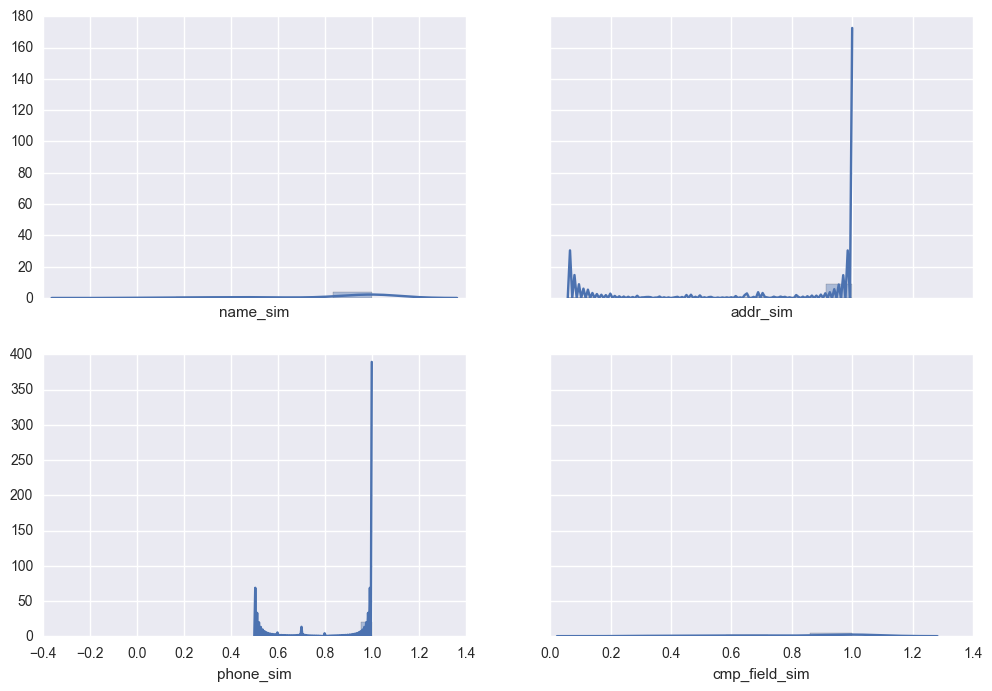

In [6]:
%matplotlib inline
sns.set(color_codes=True)

# Plot the name, addr, field, and phone CDF similarity
f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12, 8))
for ix, col in enumerate(['name_sim', 'addr_sim', 'phone_sim', 'cmp_field_sim']):
    sns.distplot(sim[col], ax=eval('ax' + str(ix)))
# Plot it
plt.show()

## Thresholds Filtering

Perceptually, it looks like the best quantile of true positives are >80% range. So we will avoid false positives and false negatives using the 80% threshold.

In [7]:
# Filter where at least cmp specificity is over 50% and similarity is over 85% per feature
sim['name_avail'] = sim.name_sim.apply(lambda x: bool(x))
sim['name_similar'] = sim.name_sim.apply(lambda x: x and x >= 0.8)
sim['addr_avail'] = sim.addr_sim.apply(lambda x: bool(x))
sim['addr_similar'] = sim.addr_sim.apply(lambda x: x and x >= 0.8)
sim['phone_avail'] = sim.phone_sim.apply(lambda x: bool(x))
sim['phone_similar'] = sim.phone_sim.apply(lambda x: x and x >= 0.8)
sim['field_avail'] = sim.cmp_field_sim.apply(lambda x: bool(x))
sim['field_similar'] = sim.cmp_field_sim.apply(lambda x: x and x >= 0.8)

# Compute specificity when similarity fields are computed/available. 
# It is possible, the fields were just not supplied; we cannot discount
# similarity just because we have nulls in the fields that are unavailable
sim['overall_sim'] = sim.apply(lambda x:
    float(np.sum([x.name_similar, x.addr_similar, x.phone_similar, x.field_similar])) / max(
        1, np.sum(
            [x.name_avail, x.addr_avail, x.phone_avail, x.field_avail])),
    axis=1)

# Filter out where at least two of the available fields match
sim = sim[sim.overall_sim >= 0.50]

# Save similarity
display(sim[sorted(sim.columns)])

,addr_avail,addr_jacc_sim,addr_lev_sim,addr_sim,...,record_id_y,record_id_y,type_x,type_y
7,True,1.00,1.00,1.00,...,23,23,french,french (classic)
158,True,1.00,1.00,1.00,...,209,209,french,french (new)
1034,True,1.00,1.00,1.00,...,9,9,american,californian
...,...,...,...,...,...,...,...,...,...
224856,True,0.63,0.78,0.71,...,199,199,french,californian
225029,True,1.00,1.00,1.00,...,197,197,american,american (new)
225041,True,0.53,0.95,0.74,...,1,1,american,steakhouses


## Findings

We found 117 positives. Original dataset suggests we have 112 confirmed duplicates. We seem to be having some false positives in our logic. We must tune the similarity thresholds better. From what we can tell, there are no false positives. See below if you can spot any false positives.

We want to cleanse, curate, and match ideally on Spark like infrastructure versus using pandas if scalability is a challenge. We have curated and linked upto a million entities in a local Spark context.<hr/>

In [8]:
## Spot all duplicates?
print sim[['name_x', 'name_y', 'addr_x', 'addr_y']].values

[[u"l'orangerie" u"l'orangerie" u'903 n. la cienega blvd.'
  u'903 n. la cienega blvd.']
 [u'la folie' u'la folie' u'2316 polk st.' u'2316 polk st.']
 [u'campanile' u'campanile' u'624 s. la brea ave.' u'624 s. la brea ave.']
 [u'matsuhisa' u'matsuhisa' u'129 n. la cienega blvd.'
  u'129 n. la cienega blvd.']
 [u'le montrachet' u'le montrachet bistro' u'3000 w. paradise rd.'
  u'3000 paradise rd.']
 [u'grill on the alley' u'grill  the' u'9560 dayton way' u'9560 dayton way']
 [u'locanda veneta' u'locanda veneta' u'3rd st.' u'8638 w. third st.']
 [u"philippe's the original" u'philippe the original'
  u'1001 n. alameda st.' u'1001 n. alameda st.']
 [u'la grotta' u'la grotta'
  u'2637 peachtree rd.  peachtree house condominium'
  u'2637 peachtree rd. ne']
 [u'brasserie le coze' u'brasserie le coze'
  u'3393 peachtree rd.  lenox square mall  near neiman marcus'
  u'3393 peachtree rd.']
 [u'le chardonnay' u'le chardonnay (los angeles)' u'8284 melrose ave.'
  u'8284 melrose ave.']
 [u'the palm